# Analyse result of regionalising industry demands using emissions

In [121]:
import sys

import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

sys.path.append('../../src/construct/')
import util

idx = pd.IndexSlice

data_path = '../../data'
build_path = '../../build'

In [ ]:
energy_balances = pd.read_csv(f'{build_path}/annual_energy_balances.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)

In [3]:
countries = {i: util.get_alpha3(i) for i in energy_balances.index.levels[3]}
years = {i: int(i) for i in range(2000, 2019)}

# Map demand to Euro-Calliope subregions

In [69]:
# Get regions
eurospores_units = gpd.read_file('../../euro-calliope/build/data/ehighways/units.geojson')

nuts3_2006 = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2006_4326_LEVL_3.geojson')
eurospores_to_nuts3 = pd.read_csv(f'{data_path}/nuts_to_regions.csv', index_col='NUTS3')


nuts3_2006 = nuts3_2006[
    (nuts3_2006.bounds.minx >= eurospores_units.total_bounds[0]) &
    (nuts3_2006.bounds.miny >= eurospores_units.total_bounds[1]) &
    (nuts3_2006.bounds.maxx <= eurospores_units.total_bounds[2]) &
    (nuts3_2006.bounds.maxy <= eurospores_units.total_bounds[3]) &
    nuts3_2006.CNTR_CODE.isin(countries.keys())
]
nuts3_2006['nuts2'] = nuts3_2006.id.str[:-1]

In [79]:
# Get data on qantity of freight shipped
freight = pd.read_csv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_na_rl3g.tsv.gz', delimiter='\t', index_col=0)
freight.index = freight.index.str.split(',', expand=True).rename(['subsector', 'unit', 'region'])
freight.columns = freight.columns.astype(int)
freight = freight.apply(util.to_numeric)

freight_sectors = {
    'GT03': 'Mining and quarrying',
    'GT04': 'Food, beverages and tobacco',
    'GT05': 'Textiles and leather',
    'GT06': 'Wood and wood products',
    'GT11': 'Machinery Equipment',
    'GT12': 'Transport Equipment',
    'GT13': 'Other Industrial Sectors'
}
relevant_nuts3 = eurospores_to_nuts3[eurospores_to_nuts3.Source == 'NUTS3'].id
relevant_nuts3.index = relevant_nuts3.index.str.replace('GR', 'EL')
freight_eu = freight.unstack().groupby(freight_sectors, level=0).sum().where(lambda x: x > 0).loc[:, idx[:, relevant_nuts3.index]].stack([0, 1])
freight_eu = freight_eu.to_frame('freight').set_index(freight_eu.index.get_level_values('region').str[:-1], append=True).rename_axis(index=['subsector', 'year', 'nuts3', 'nuts2'])

In [39]:
# Get data on number of employees
industry_activity = pd.read_csv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/sbs_r_nuts06_r2.tsv.gz', delimiter='\t', index_col=0)
industry_activity.index = industry_activity.index.str.split(',', expand=True).rename(['cat_code', 'indicator', 'region'])

industrial_activity_codes = pd.read_csv(
    data_path + '/industry/industry_activity_codes.csv', 
    skipfooter=7, index_col=0, header=0, engine='python'
).dropna(subset=['Eurostat sector'])

# V11210 == local units,  V16110 == persons employed,  	V13320 == wages and salaries
industry_employees = industry_activity.xs('V16110', level='indicator').apply(util.to_numeric).loc[industrial_activity_codes['Eurostat sector'].dropna().index]
industry_employees.columns = industry_employees.columns.astype(int)
industry_employees = (
    industry_employees
    .unstack()
    .groupby(industrial_activity_codes['Eurostat sector'].to_dict()).sum(min_count=1)
    .stack([0, 1])
    .rename_axis(index=['subsector', 'year', 'region'])
)

In [82]:
# Combine freight and employee data
freight_employees = pd.concat(
    [freight_eu['freight'].reset_index('nuts3'), 
     industry_employees.reindex(freight_eu.droplevel('nuts3').index).to_frame('employees_nuts2')], 
    axis=1
).set_index('nuts3', append=True)
freight_employees = (
    freight_employees
    .set_index(freight_employees.index.get_level_values('nuts2').str[:2].rename('country_code'), append=True)
    .set_index(freight_employees.index.get_level_values('nuts2').str[:3].rename('nuts1'), append=True)
    .set_index(relevant_nuts3.reindex(freight_employees.index.get_level_values('nuts3')), append=True)
)
freight_employees['employees_nuts1'] = industry_employees.reindex(freight_employees.droplevel(['nuts2', 'nuts3', 'country_code']).index).values
freight_employees['employees_nuts0'] = industry_employees.reindex(freight_employees.droplevel(['nuts2', 'nuts3', 'nuts1']).index).values

# Get contribution of ehighways regions to national industry activity in each subsector
# We do this by going from NUTS2 employment data to NUTS3 by using freight in each subregion
# Then going from NUTS3 up to Euro-Calliope regions
# Where no employment data is available at any spatial resolution (e.g. in Switzerland), freight data is used directly
freight_per_nuts3_nuts2_intensity = freight_employees['freight'].div(freight_employees['freight'].sum(level=['subsector', 'year', 'nuts2']))
freight_per_nuts3_nuts1_intensity = freight_employees['freight'].div(freight_employees['freight'].sum(level=['subsector', 'year', 'nuts1']))
freight_per_nuts3_nuts0_intensity = freight_employees['freight'].div(freight_employees['freight'].sum(level=['subsector', 'year', 'country_code']))
employees_per_nuts3 = (
    freight_employees['employees_nuts2'].mul(freight_per_nuts3_nuts2_intensity)
    .fillna(freight_employees['employees_nuts1'].mul(freight_per_nuts3_nuts1_intensity))
    .fillna(freight_employees['employees_nuts0'].mul(freight_per_nuts3_nuts0_intensity))
)
employees_per_eurospores = employees_per_nuts3.sum(level=['subsector', 'year', 'id', 'country_code'], min_count=1)
freight_per_eurospores = freight_employees['freight'].sum(level=['subsector', 'year', 'id', 'country_code'], min_count=1)
subsector_per_eurospores_national_intensity = (
    employees_per_eurospores.div(employees_per_eurospores.sum(level=['subsector', 'year', 'country_code']))
    .fillna(freight_per_eurospores.div(freight_per_eurospores.sum(level=['subsector', 'year', 'country_code'])))
)

# Restructure for plotting
subsector_employee_freight_intensity = (
    subsector_per_eurospores_national_intensity
    .unstack('subsector')
    .xs(2014)
    .droplevel('country_code')
)

Text(0.5, 0, 'Ratio of subsectoral regional contribution in all years that are not 2014 with data for 2014')

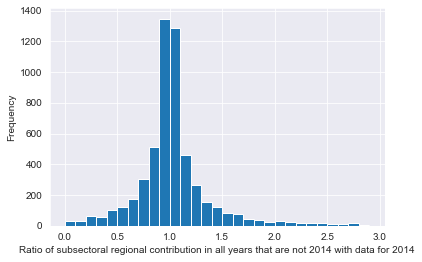

In [201]:
# We will use 2014 data, but we check here that it's vaguely OK to do so (i.e. is 2014 data representative of all other years)
ax = subsector_per_eurospores_national_intensity.unstack('year').div(
    subsector_per_eurospores_national_intensity.xs(2014, level='year'), axis=0
).drop(2014, axis=1).stack().hist(bins=[i/10 for i in range(30)])
ax.set_ylabel('Frequency')
ax.set_xlabel('Ratio of subsectoral regional contribution in all years that are not 2014 with data for 2014')

In [ ]:
# Get emissions data
emissions = gpd.read_file(f'{build_path}/all_industrial_ets_eprtr_sites.geojson')
# Map industries to Euro-calliope regions
emissions_eu = gpd.overlay(emissions, eurospores_units)

emissions_intensity_eu = (
    emissions_eu
    .groupby(['id', 'Subsector', 'country_code']).sum()
    .apply(lambda x: x / x.sum(level=['Subsector', 'country_code']))
    .reset_index('country_code', drop=True)
    .emissions
    .drop('Other Industrial Sectors')
    .unstack(0)
)

In [ ]:
# Combine freight/employee subsector intensities with emissions subsector intensities
eurospores_industry_intensity = (
    eurospores_units
    .merge(emissions_intensity_eu, left_on='id', right_index=True, how='outer')
    .merge(subsector_employee_freight_intensity, left_on='id', right_index=True, how='outer')
    .fillna(0).to_crs('epsg:3035')
)

subsectors = eurospores_industry_intensity.columns.difference(eurospores_units.columns)
eurospores_industry_intensity.loc[eurospores_industry_intensity['type'] == 'country', subsectors] = 1

In [ ]:
national_units = eurospores_industry_intensity.dissolve('country_code').simplify(10000)  # takes a minute, so it's better to run independently

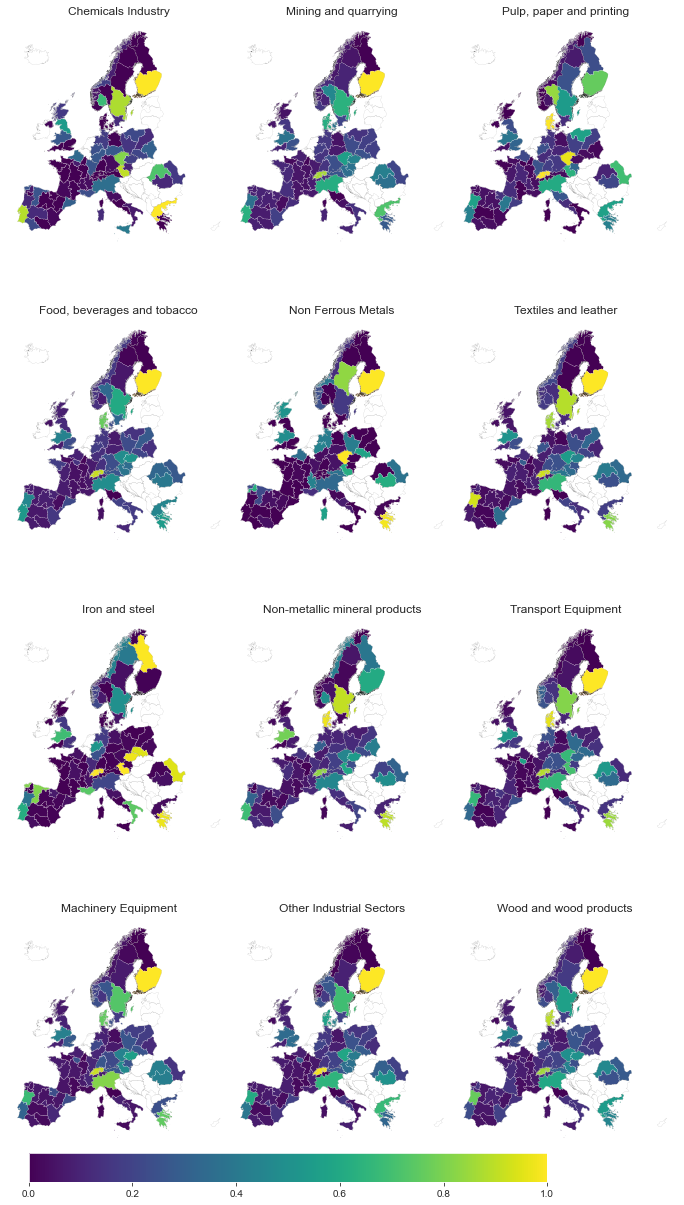

In [200]:
fig, ax = plt.subplots(4, 3, figsize=(12, 20), gridspec_kw={"wspace": 0, "hspace": 0})
_ax1 = 0
_ax2 = 0
for subsector in subsectors:
    if _ax1 > 3:
        _ax1 = 0
        _ax2 += 1
    ax[_ax1, _ax2].axis('off')
    eurospores_industry_intensity[eurospores_industry_intensity['type'] != 'country'].plot(
        subsector, cmap='viridis', edgecolor='white', linewidth=0.1, ax=ax[_ax1, _ax2], vmin=0, vmax=1
    )
    ax[_ax1, _ax2].set_title(subsector)
    national_units.plot(facecolor='None', edgecolor='black', linewidth=0.05, ax=ax[_ax1, _ax2])
    _ax1 += 1
    
fig.subplots_adjust(bottom=0.05)
cbar_ax = fig.add_axes([0.15, 0.05, 0.6, 0.02])
fig.colorbar(mappable=ax[0, 0].collections[0], cax=cbar_ax, orientation='horizontal')


In [187]:
# Go from regional contributions to regional energy consumption
eurospores_industry_intensity_df = eurospores_industry_intensity.set_index(['id', 'country_code'])[subsectors].rename_axis(columns='cat_name').stack()
aligned_dfs = industry_energy_balances.align(eurospores_industry_intensity_df)
eurospores_industry_energy_df = aligned_dfs[0].mul(aligned_dfs[1]).where(lambda x: x > 0).dropna()